# Data Preprocessing Tutorial

This tutorial demonstrates the complete data preprocessing workflow for LineageVI analysis, including data loading, filtering, normalization, and quality control steps.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lineagevi as linvi
import scanpy as sc
import scvelo as scv
import numpy as np
import os


In [3]:
raw_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/inputs/anndata/raw'
dataset_name = 'pancreas'
raw_adata_path = os.path.join(raw_path, dataset_name + '.h5ad')
os.makedirs(raw_path, exist_ok=True)
adata = scv.datasets.pancreas(raw_adata_path)

In [4]:
adata.layers['counts'] = adata.layers['spliced'].copy() + adata.layers['unspliced'].copy()
adata.X = adata.layers['counts'].copy()

In [5]:
adata.layers['unspliced_counts'] = adata.layers['unspliced'].copy()
adata.layers['spliced_counts'] = adata.layers['spliced'].copy()

In [6]:
annotation_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/inputs/gene_sets/'
annotation_name = 'msigdb_development_or_pancreas.gmt'
file_path = os.path.join(annotation_path, annotation_name)
os.makedirs(annotation_path, exist_ok=True)

linvi.utils.add_annotations(
    adata, 
    files=[file_path],
    min_genes=12,
    varm_key='I',
    uns_key='terms',
    clean=True,
    genes_use_upper=True)

adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True, log=True)

NameError: name 'scv' is not defined

In [8]:
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)


In [ ]:
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=100)
scv.pp.neighbors(adata, n_neighbors=200, use_rep='X_pca')
scv.pp.moments(adata, n_neighbors=200)
sc.pp.scale(adata, layer='Mu')
sc.pp.scale(adata, layer='Ms')

computing neighbors


/var/folders/1x/8dphwyvs0j504xrq138nfssh0000gn/T/ipykernel_30025/402894629.py:4: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  scv.pp.neighbors(adata, n_neighbors=200)


    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20 + 1, metric='euclidean', n_jobs=-1)
nbrs.fit(adata.obsm['X_pca'])
distances, indices = nbrs.kneighbors(adata.obsm['X_pca'])

adata.uns['indices'] = indices

In [11]:
annotation_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/inputs/gene_sets/'
annotation_name = 'msigdb_development_or_pancreas.gmt'
file_path = os.path.join(annotation_path, annotation_name)
os.makedirs(annotation_path, exist_ok=True)

linvi.utils.add_annotations(
    adata, 
    files=[file_path],
    min_genes=12,
    varm_key='I',
    uns_key='terms',
    clean=True,
    genes_use_upper=True)

adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [12]:
processed_dir_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/inputs/anndata/processed/'
processed_adata_path = os.path.join(processed_dir_path, dataset_name + '.h5ad')
os.makedirs(processed_dir_path, exist_ok=True)
adata.write_h5ad(processed_adata_path)

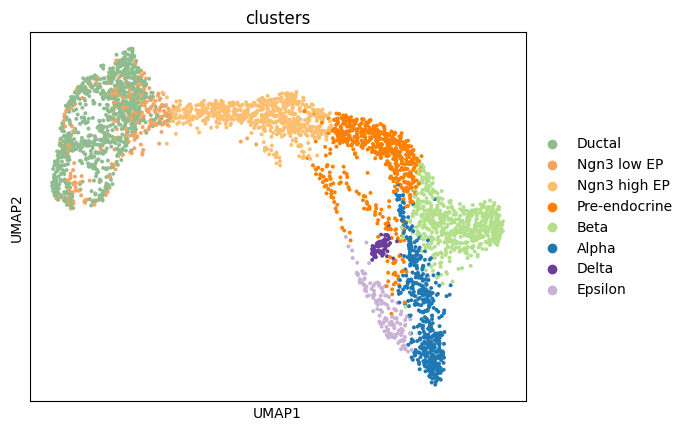

In [13]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')